<a href="https://colab.research.google.com/github/6poh66/FraudDetectionBlockchain/blob/main/Fraud_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [18]:
!pip install -q kaggle

# **Dataset Download**

In [23]:
!kaggle datasets download -d mlg-ulb/creditcardfraud
!unzip -q creditcardfraud.zip


Dataset URL: https://www.kaggle.com/datasets/mlg-ulb/creditcardfraud
License(s): DbCL-1.0
creditcardfraud.zip: Skipping, found more recently modified local copy (use --force to force download)
replace creditcard.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
--------------------------------------------------


In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler
from imblearn.over_sampling import SMOTE


# **Dataset Load**

In [30]:
# Load Dataset
df = pd.read_csv('creditcard.csv')

# EXPLORATORY DATA ANALYSIS (EDA)
print("\nDataset Head:")
print(df.head())

print("\nDataset Info:")
df.info()

print("\nNull values:")
print(df.isnull().sum().max())


Dataset Head:
   Time        V1        V2        V3        V4        V5        V6        V7  \
0   0.0 -1.359807 -0.072781  2.536347  1.378155 -0.338321  0.462388  0.239599   
1   0.0  1.191857  0.266151  0.166480  0.448154  0.060018 -0.082361 -0.078803   
2   1.0 -1.358354 -1.340163  1.773209  0.379780 -0.503198  1.800499  0.791461   
3   1.0 -0.966272 -0.185226  1.792993 -0.863291 -0.010309  1.247203  0.237609   
4   2.0 -1.158233  0.877737  1.548718  0.403034 -0.407193  0.095921  0.592941   

         V8        V9  ...       V21       V22       V23       V24       V25  \
0  0.098698  0.363787  ... -0.018307  0.277838 -0.110474  0.066928  0.128539   
1  0.085102 -0.255425  ... -0.225775 -0.638672  0.101288 -0.339846  0.167170   
2  0.247676 -1.514654  ...  0.247998  0.771679  0.909412 -0.689281 -0.327642   
3  0.377436 -1.387024  ... -0.108300  0.005274 -0.190321 -1.175575  0.647376   
4 -0.270533  0.817739  ... -0.009431  0.798278 -0.137458  0.141267 -0.206010   

        V26      

# **Class Distribution**


Class Distribution (Before SMOTE):
Class
0    284315
1       492
Name: count, dtype: int64


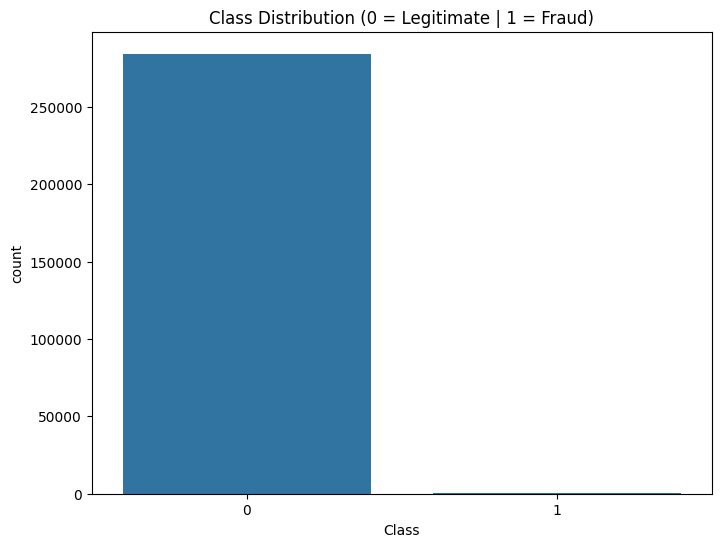

In [31]:
print("\nClass Distribution (Before SMOTE):")
class_counts = df['Class'].value_counts()
print(class_counts)

# Visualize the class imbalance
plt.figure(figsize=(8, 6))
sns.countplot(x='Class', data=df)
plt.title('Class Distribution (0 = Legitimate | 1 = Fraud)')
plt.show()

Dataset is highly imbalanced.